# Solution CNN_Melanoma Detection assignment

##### To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.




In [ ]:
#pip uninstall tensorflow
#pip install tensorflow==2.12.0 --upgrade


In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
!unzip /gdrive/MyDrive/ColabNotebooks/CNN_assignment.zip -d /gdrive/MyDrive/ColabNotebooks/CNN_assignment

Archive:  /gdrive/MyDrive/ColabNotebooks/CNN_assignment.zip
replace /gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The Internation

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
!ls

sample_data


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Writing the train dataset
## Note use seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing the images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write the validation dataset
## Note use seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resize the images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# Listing out all the classes of skin cancer and store them in a list.
# Finding the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [ ]:
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))

32
32


32
32


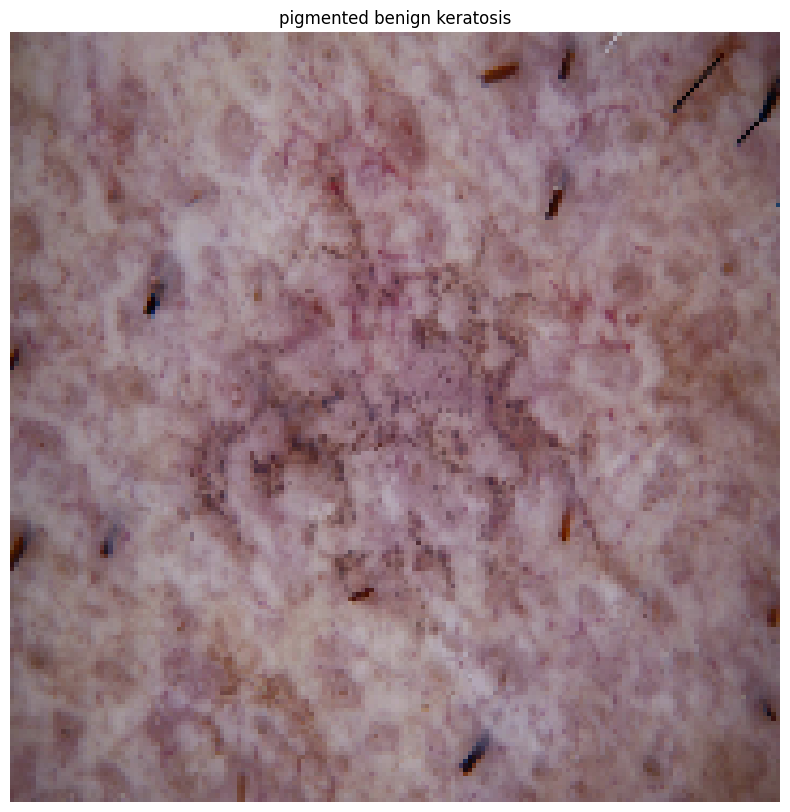

In [ ]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))
  plt.imshow(images[10].numpy().astype("uint8"))
  plt.title(class_names[labels[10]])
  plt.axis("off")


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

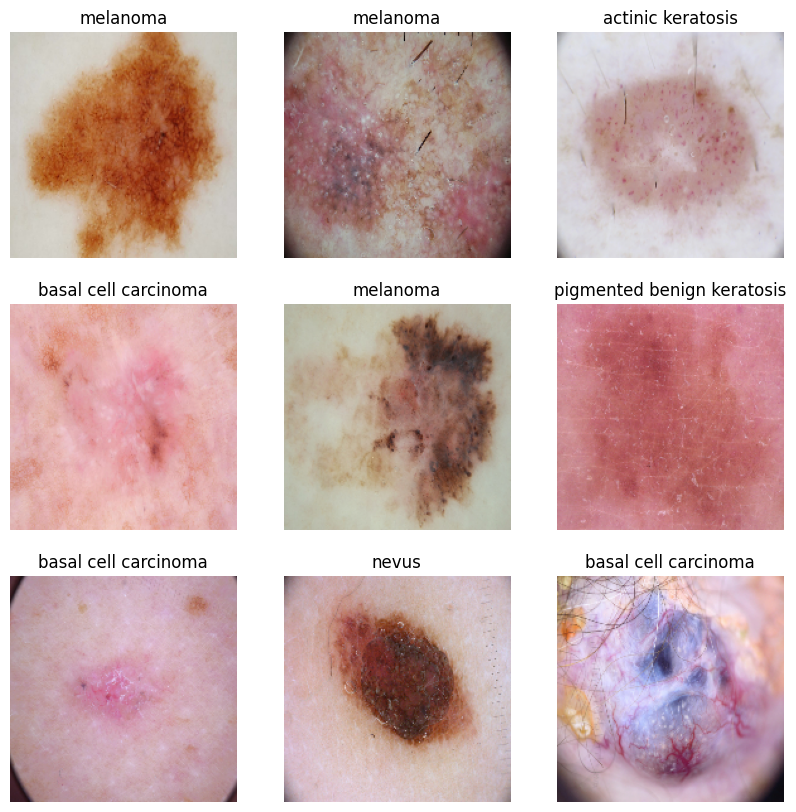

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(5):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Using training or validation data to visualize

In [ ]:
print(type(train_ds))
print(len(train_ds))


<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
56


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
#overlaps data preprocessing and model execution while training., Speed up training
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
num_classes = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  layers.MaxPooling2D(),

  #We slide over the feature map and extract tiles of a specified size.
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.MaxPooling2D(),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ##Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  #fully connected layer
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer.
  #A fully connected layer is also known as a dense layer.

  layers.Dense(128, activation='relu'),

  #Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
  #It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
  #Dense implements the operation: output = activation(dot(input, kernel)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])



### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

In [ ]:
### Todo, choose an appropirate optimiser and loss function
#RMSprop. RMSprop is a very effective, but currently unpublished adaptive learning rate method
#Adam. Adam is a recently proposed update that looks a bit like RMSProp with momentum. The (simplified) update looks as follows:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 110s 2s/step - loss: 1.9022 - accuracy: 0.2941 - val_loss: 1.6086 - val_accuracy: 0.4586
Epoch 2/20
56/56 [==============================] - 73s 1s/step - loss: 1.5633 - accuracy: 0.4520 - val_loss: 1.3926 - val_accuracy: 0.5347
Epoch 3/20
56/56 [==============================] - 68s 1s/step - loss: 1.3492 - accuracy: 0.5318 - val_loss: 1.3973 - val_accuracy: 0.5213
Epoch 4/20
56/56 [==============================] - 69s 1s/step - loss: 1.2763 - accuracy: 0.5485 - val_loss: 1.2905 - val_accuracy: 0.5660
Epoch 5/20
56/56 [==============================] - 70s 1s/step - loss: 1.1143 - accuracy: 0.6155 - val_loss: 1.4660 - val_accuracy: 0.5324
Epoch 6/20
56/56 [==============================] - 66s 1s/step - loss: 1.0577 - accuracy: 0.6323 - val_loss: 1.4759 - val_accuracy: 0.5436
Epoch 7/20
56/56 [==============================] - 73s 1s/step - loss: 0.9878 - accuracy: 0.6484 - val_loss: 1.5770 - val_accuracy: 0.5324
Epoch 8/20
56/56 [=

### Train the model

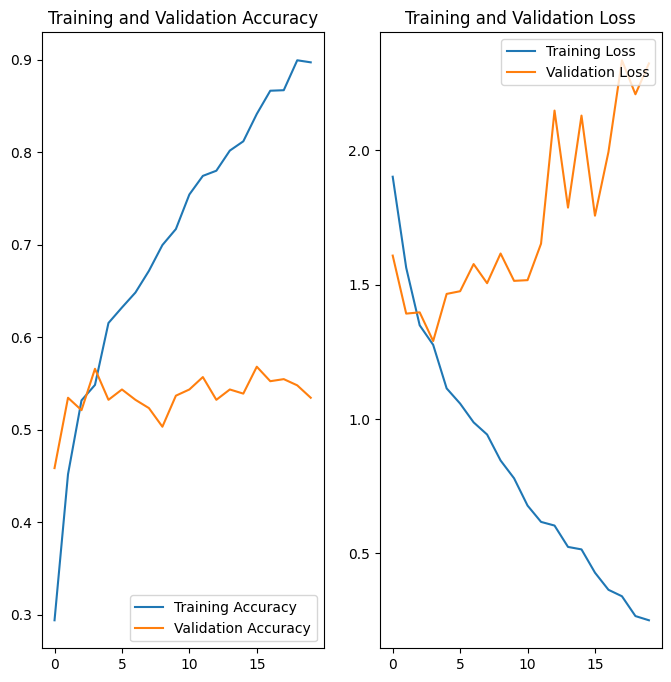

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.Flatten(),
  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  layers.Dense(128, activation='relu'),
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])


### Visualizing training results

In [ ]:
# Analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)

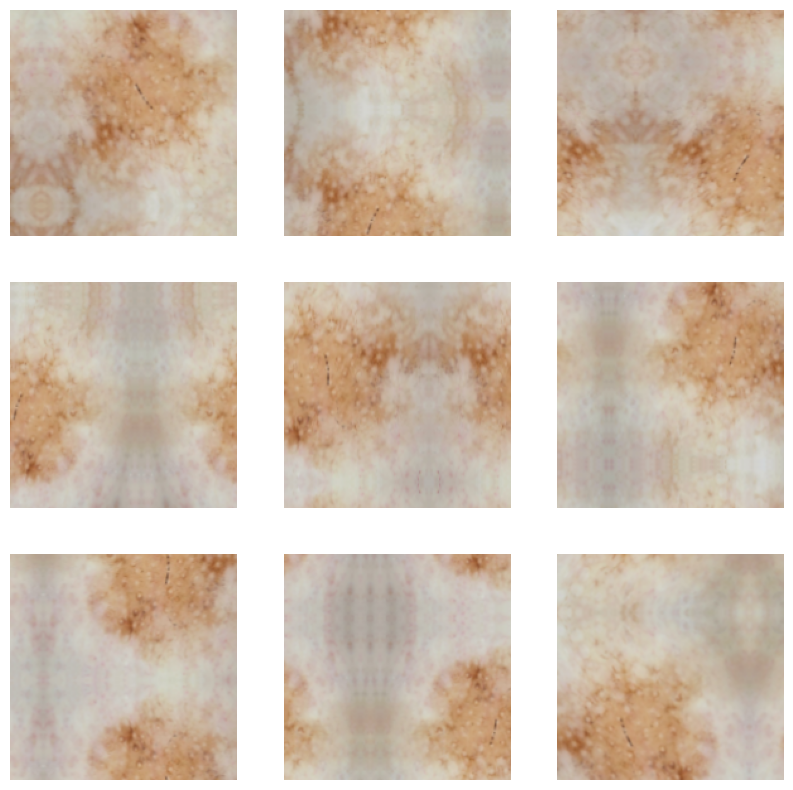

In [ ]:
# Visualizing how the augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Create the model, compile and train the model


In [ ]:
## Droping out layer if there is an evidence of overfitting findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [92]:
## Training the model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 487s 9s/step - loss: 2.3870 - accuracy: 0.2031 - val_loss: 2.0334 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 478s 9s/step - loss: 1.9768 - accuracy: 0.2455 - val_loss: 2.7346 - val_accuracy: 0.2461
Epoch 3/20
56/56 [==============================] - 474s 8s/step - loss: 2.0614 - accuracy: 0.1853 - val_loss: 2.0293 - val_accuracy: 0.2170
Epoch 4/20
56/56 [==============================] - 460s 8s/step - loss: 1.9796 - accuracy: 0.2400 - val_loss: 2.0209 - val_accuracy: 0.2103
Epoch 5/20
56/56 [==============================] - 472s 8s/step - loss: 1.9499 - accuracy: 0.2561 - val_loss: 2.0312 - val_accuracy: 0.2125
Epoch 6/20
56/56 [==============================] - 468s 8s/step - loss: 1.9155 - accuracy: 0.2706 - val_loss: 1.8186 - val_accuracy: 0.2975
Epoch 7/20
56/56 [==============================] - 471s 8s/step - loss: 1.8279 - accuracy: 0.3125 - val_loss: 1.7447 - val_accuracy: 0.3714
Epoch 8/20
56

### Visualizing the results

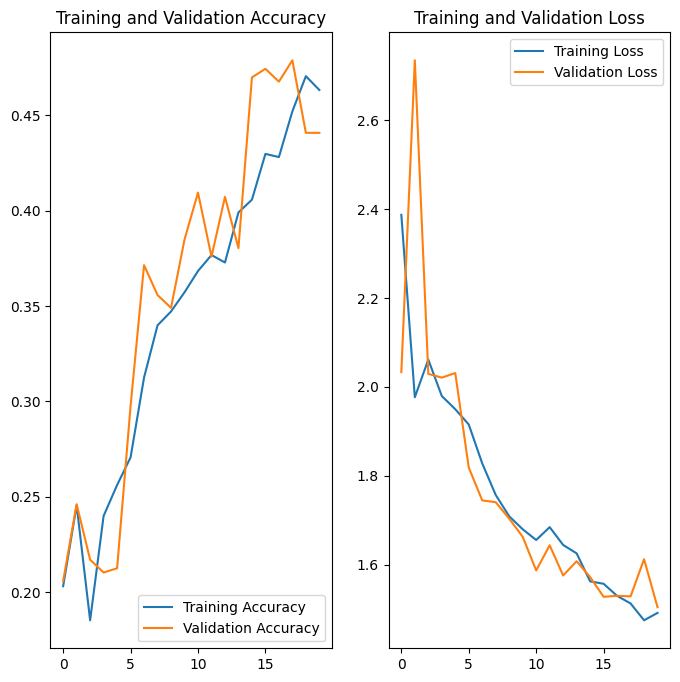

In [93]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [96]:
# For convenience, let us set up the path for the training and validation sets
train_dir = os.path.join('/gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
val_dir = os.path.join('/gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [97]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Setting batch size and image size
batch_size = 100
IMG_SHAPE = 224

# Create training images generator
#Generate batches of tensor image data with real-time data augmentation.
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
#https://keras.io/api/preprocessing/image/
#Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories
train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

# Create validation images generator
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [98]:
#Create a CNN model
#Experiment #1
#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

# Import layers explicitly to keep our code compact
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D


model = Sequential()

#2D convolution layer (e.g. spatial convolution over images).
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
#Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))

#Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Flattens the input. Does not affect the batch size.
model.add(Flatten())

#https://keras.io/api/layers/regularization_layers/dropout/
#The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))

#Regular densely-connected NN layer.
#Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
#It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
#Dense implements the operation: output = activation(dot(input, kernel)
model.add(Dense(9))

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
epochs = 20

history = model.fit(
  train_data_gen,
  validation_data=val_data_gen,
  epochs=10
)


Epoch 1/10
23/23 [==============================] - 228s 10s/step - loss: 2.8368 - accuracy: 0.2144 - val_loss: 2.1908 - val_accuracy: 0.2034
Epoch 2/10
23/23 [==============================] - 225s 9s/step - loss: 1.8342 - accuracy: 0.3269 - val_loss: 2.1697 - val_accuracy: 0.2627
Epoch 3/10
23/23 [==============================] - 217s 9s/step - loss: 1.6160 - accuracy: 0.4212 - val_loss: 2.1731 - val_accuracy: 0.2712
Epoch 4/10
23/23 [==============================] - 222s 10s/step - loss: 1.5360 - accuracy: 0.4542 - val_loss: 2.4602 - val_accuracy: 0.3136
Epoch 5/10
23/23 [==============================] - 216s 9s/step - loss: 1.4521 - accuracy: 0.4935 - val_loss: 2.4284 - val_accuracy: 0.3051
Epoch 6/10
23/23 [==============================] - 218s 9s/step - loss: 1.4203 - accuracy: 0.5087 - val_loss: 2.1477 - val_accuracy: 0.3305
Epoch 7/10
23/23 [==============================] - 230s 10s/step - loss: 1.3592 - accuracy: 0.5190 - val_loss: 2.2882 - val_accuracy: 0.3559
Epoch 8/10

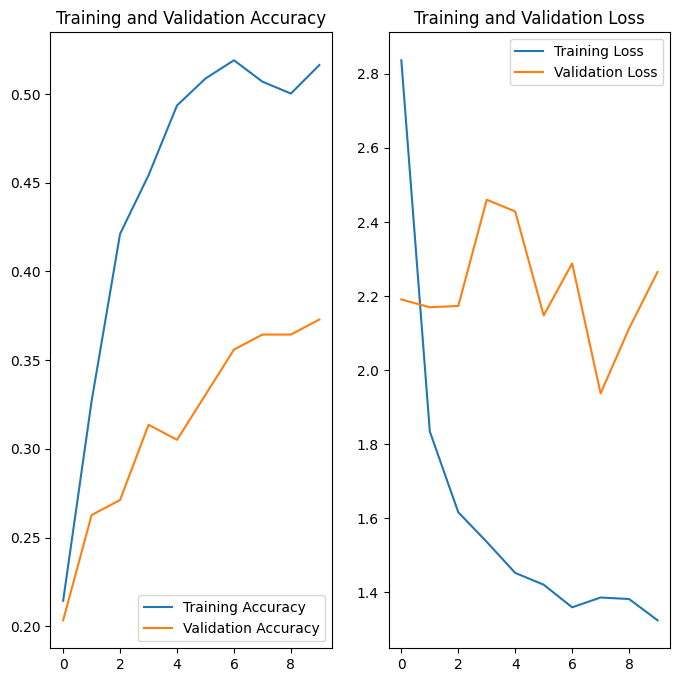

In [99]:
import matplotlib.pyplot as plt
epochs=10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)



plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [100]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [102]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/gdrive/MyDrive/ColabNotebooks/CNN_assignment/...,actinic keratosis
1,/gdrive/MyDrive/ColabNotebooks/CNN_assignment/...,actinic keratosis
2,/gdrive/MyDrive/ColabNotebooks/CNN_assignment/...,actinic keratosis
3,/gdrive/MyDrive/ColabNotebooks/CNN_assignment/...,actinic keratosis
4,/gdrive/MyDrive/ColabNotebooks/CNN_assignment/...,actinic keratosis
...,...,...
2234,/gdrive/MyDrive/ColabNotebooks/CNN_assignment/...,vascular lesion
2235,/gdrive/MyDrive/ColabNotebooks/CNN_assignment/...,vascular lesion
2236,/gdrive/MyDrive/ColabNotebooks/CNN_assignment/...,vascular lesion
2237,/gdrive/MyDrive/ColabNotebooks/CNN_assignment/...,vascular lesion


Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


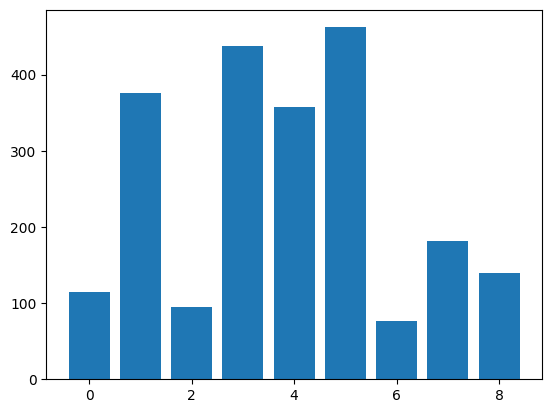

In [103]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [104]:
!pip install Augmentor

In [106]:
#https://github.com/mdbloice/Augmentor
#https://github.com/mdbloice/Augmentor
datapath = r'/gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis'
import Augmentor
p = Augmentor.Pipeline(datapath)
#Every function requires to specify a probability, which is used to decide if an operation is applied to an image as it is passed through the augmentation pipeline.
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
p.sample(150)
p.process()


Initialised with 114 image(s) found.
Output directory set to /gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D58B11C7E50>: 100%|██████████| 150/150 [00:09<00:00, 15.01 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D58B1BD4460>: 100%|██████████| 114/114 [00:05<00:00, 19.76 Samples/s]


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing the initial image data set.<br>
2. Define a number of operations to perform on this data set using the `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [115]:
#path_to_training_dataset="/gdrive/MyDrive/ColabNotebooks/CNN_assignment/SC/Train//"
path_to_training_dataset="/gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D58B968ED70>: 100%|██████████| 500/500 [00:24<00:00, 20.51 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D58B9BF7580>: 100%|██████████| 500/500 [00:23<00:00, 21.19 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D58B1BD5930>: 100%|██████████| 500/500 [00:25<00:00, 19.67 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x1536 at 0x7D58B1B6FC40>: 100%|██████████| 500/500 [01:52<00:00,  4.46 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7D58B1095750>: 100%|██████████| 500/500 [01:50<00:00,  4.52 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D58B94E0EB0>: 100%|██████████| 500/500 [00:27<00:00, 18.42 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D58B45B8850>: 100%|██████████| 500/500 [00:50<00:00,  9.91 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D58B1077FD0>: 100%|██████████| 500/500 [00:27<00:00, 17.97 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train//vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D58B1B6F7C0>: 100%|██████████| 500/500 [00:25<00:00, 19.52 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [116]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4764


### Lets see the distribution of augmented data after adding new images to the original training data.

In [117]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033494.jpg_1316a9a0-9237-4e2e-be54-39c9f08b7fe5.jpg',
 '/gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026650.jpg_60deda5b-e10b-4957-b556-55059b95914a.jpg',
 '/gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025992.jpg_9fea23b9-3c13-4414-a263-47a3975a8382.jpg',
 '/gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031335.jpg_156dffc5-1838-4ef6-ab76-d78ee530c27e.jpg',
 '/gdrive/MyDrive/ColabNotebooks/CNN_assignment/Skin cancer ISIC The International Skin 

In [118]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [119]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [120]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-120-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [121]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
actinic keratosis             878
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [122]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

####Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [123]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

####Compile the model (Choose optimizer and loss function appropriately)

In [124]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

####Train the  model

In [125]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 85s 1s/step - loss: 2.0593 - accuracy: 0.2467 - val_loss: 1.8754 - val_accuracy: 0.3289
Epoch 2/20
56/56 [==============================] - 89s 2s/step - loss: 1.7676 - accuracy: 0.3460 - val_loss: 1.6348 - val_accuracy: 0.4049
Epoch 3/20
56/56 [==============================] - 98s 2s/step - loss: 1.5473 - accuracy: 0.4464 - val_loss: 1.5838 - val_accuracy: 0.4228
Epoch 4/20
56/56 [==============================] - 76s 1s/step - loss: 1.4630 - accuracy: 0.4833 - val_loss: 1.4193 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 74s 1s/step - loss: 1.3722 - accuracy: 0.5134 - val_loss: 1.4177 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 70s 1s/step - loss: 1.2678 - accuracy: 0.5435 - val_loss: 1.3947 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 67s 1s/step - loss: 1.2257 - accuracy: 0.5714 - val_loss: 1.3923 - val_accuracy: 0.5459
Epoch 8/20
56/56 [==

####Visualize the model results

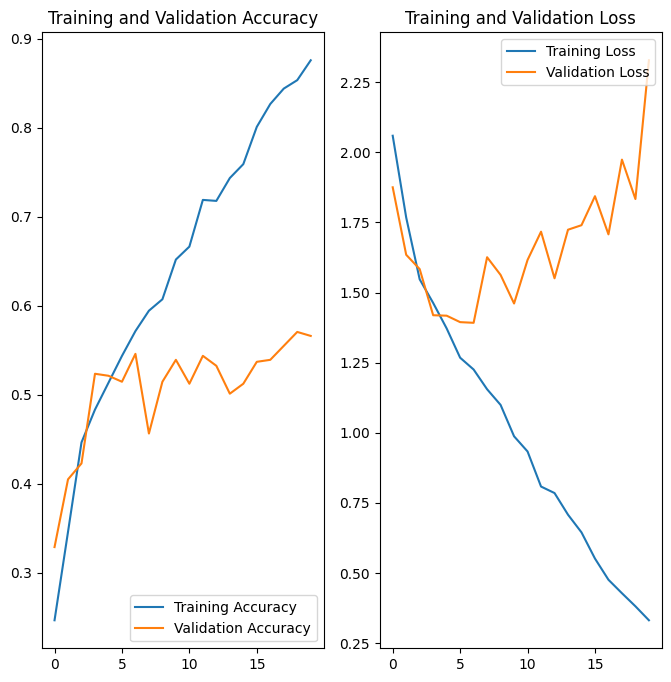

In [126]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()